In [2]:
import pandas as pd
import numpy as np
import time
import os
import copy
import json

# 시각화 관련 
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

# 파이토치 관련
import torch
import torch.nn as nn  # 신경망 과 관련된 클래스&함수
import torch.optim as optim  # 최적화 
from torch.nn import functional as F  # 활성화 함수 
from torch.utils.data import Dataset, DataLoader  
from torchvision import models  # 이미지 분류를 위한 사전 훈련된 모델
import torchvision.transforms as transforms  # 이미지변환을 위한 함수


# 증강 관련
import albumentations
from albumentations.pytorch.transforms import ToTensorV2

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# load Dataset

In [3]:
# 디렉토리 정의
BASE_DIR = "/kaggle/input/cassava-leaf-disease-classification/"

In [4]:
train = pd.read_csv(BASE_DIR+'train.csv') # train.csv 파일에는 이미지 넘버와 라벨링
train.head()

image_id  label
0  1000015157.jpg      0
1  1000201771.jpg      3
2   100042118.jpg      1
3  1000723321.jpg      1
4  1000812911.jpg      3

### 참고label_num_to_disease_map.json 내용

{"0": "Cassava Bacterial Blight (CBB)", "1": "Cassava Brown Streak Disease (CBSD)", "2": "Cassava Green Mottle (CGM)", "3": "Cassava Mosaic Disease (CMD)", "4": "Healthy"}

In [5]:
# json 파일 열고 해당 내용을 mapping 변수에 저장
# mapping 변수에 저장된 내용은 추후 레이블을 의미 있는 질병 이름으로 변환하는 데 사용
with open(BASE_DIR+'label_num_to_disease_map.json') as f: # with 문을 사용하면 파일을 사용하고 나서 자동으로 닫아
    mapping = json.loads(f.read())
    
    # mapping 사전의 키와 값을 순회하면서, 각 키를 정수로 변환하여 새로운 사전을 생성   
    # mapping.items(): mapping 사전의 (키, 값) 쌍을 반환
    # for k, v in mapping.items(): mapping.items()에서 (키, 값) 쌍을 하나씩 가져와 변수 k와 v에 할당 
    mapping = {int(k): v for k, v in mapping.items()}
mapping

{0: 'Cassava Bacterial Blight (CBB)',
 1: 'Cassava Brown Streak Disease (CBSD)',
 2: 'Cassava Green Mottle (CGM)',
 3: 'Cassava Mosaic Disease (CMD)',
 4: 'Healthy'}

In [6]:
# label열의 값을 mapping을 사용해 질병 이름으로 바꾸고 label_names에 저장
train['label_names'] = train['label'].map(mapping)

# 변환된 결과를 확인하기 위해 데이터프레임의 첫 부분을 출력
train.head()


image_id  label                          label_names
0  1000015157.jpg      0       Cassava Bacterial Blight (CBB)
1  1000201771.jpg      3         Cassava Mosaic Disease (CMD)
2   100042118.jpg      1  Cassava Brown Streak Disease (CBSD)
3  1000723321.jpg      1  Cassava Brown Streak Disease (CBSD)
4  1000812911.jpg      3         Cassava Mosaic Disease (CMD)

In [7]:
# class_id와 일치하는 레이블을 가진 이미지를 선택, 해당 이미지들을 그래프로 표시


def plot_images(class_id, label, total_images=6):
    # 타겟 클래스 ID에 해당하는 이미지 ID를 가져오기
    plot_list = train[train['label']==class_id].sample(total_images)['image_id'].tolist()
    
    # 이미지의 레이블을 리스트로 생성
    labels = [label for i in range(total_images)]
    
    # 서브플롯 크기 자동적으로 맞춰지게 설정
    size = int(np.sqrt(total_images))
    if size*size < total_images:
        size += 1
    
    # 그림의 크기를 설정합니다.
    plt.figure(figsize=(15,15))
    
    # 서브플롯에 이미지를 보이게
    for index, (image_id, label) in enumerate(zip(plot_list, labels)):
        plt.subplot(size, size, index+1)
        image = Image.open(str(BASE_DIR+'train_images/'+image_id))
        plt.imshow(image)
        plt.title(label, fontsize=14)
        plt.axis('off')
        
    
    plt.show()


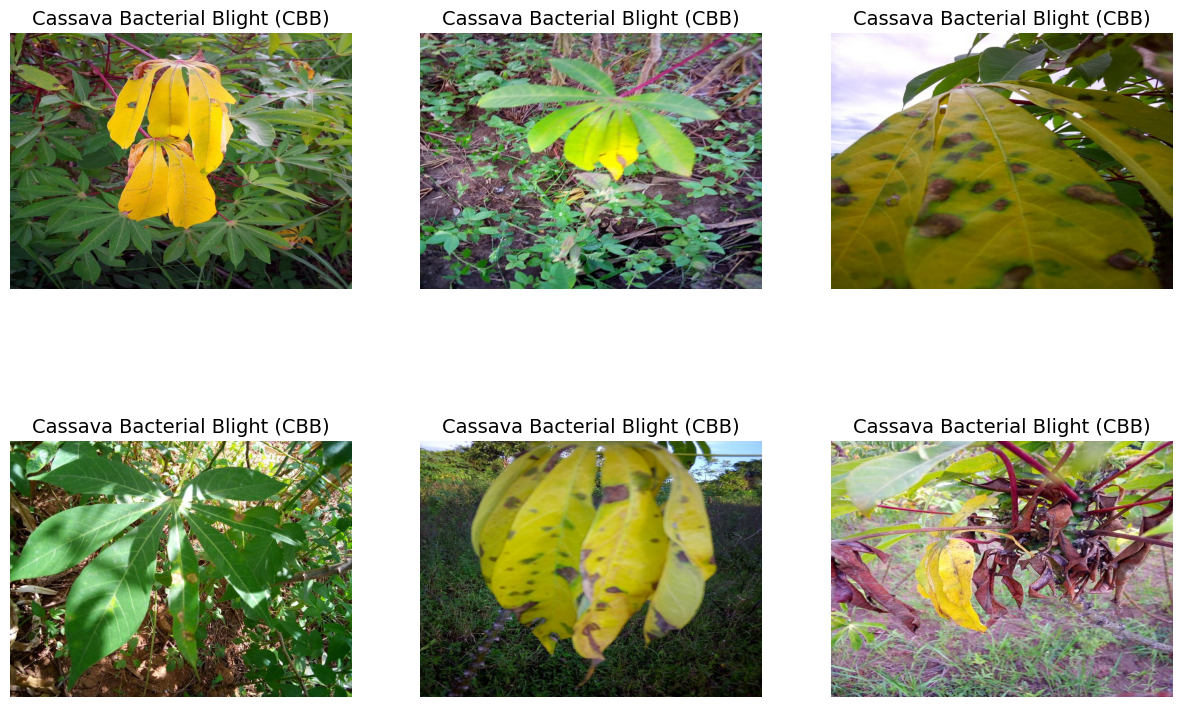

In [8]:
plot_images(0, mapping[0], 6) # class id, image_id, 그림 갯수

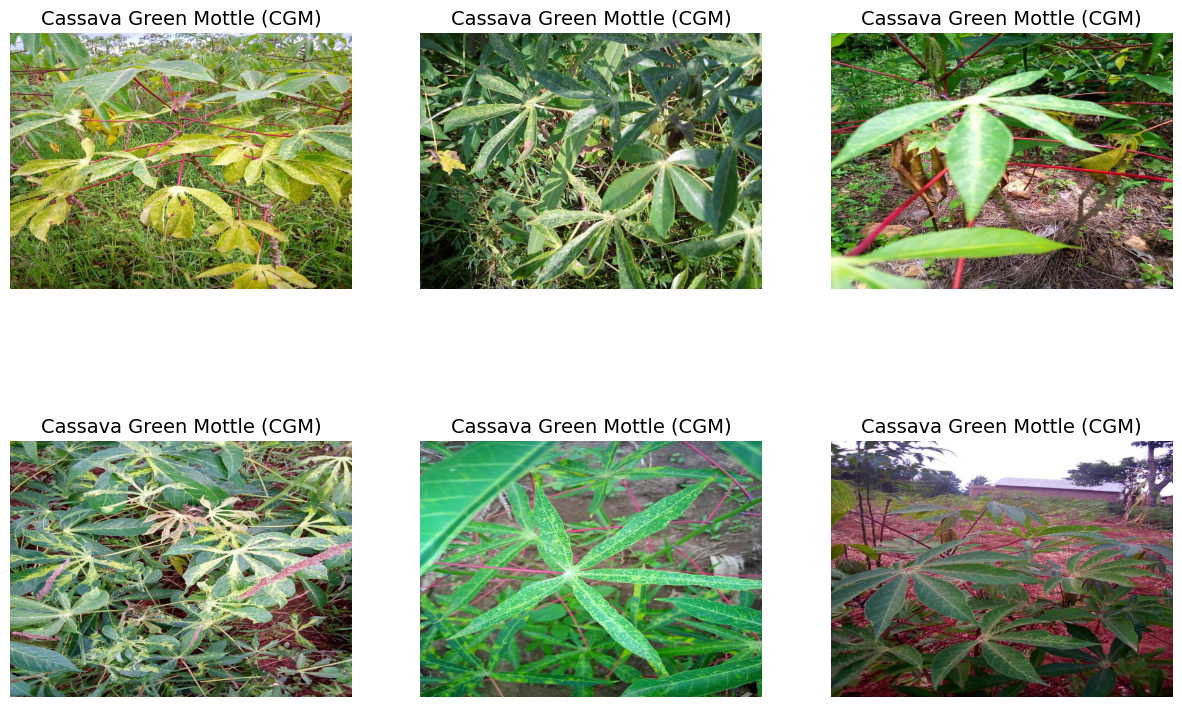

In [9]:
plot_images(2, mapping[2], 6)

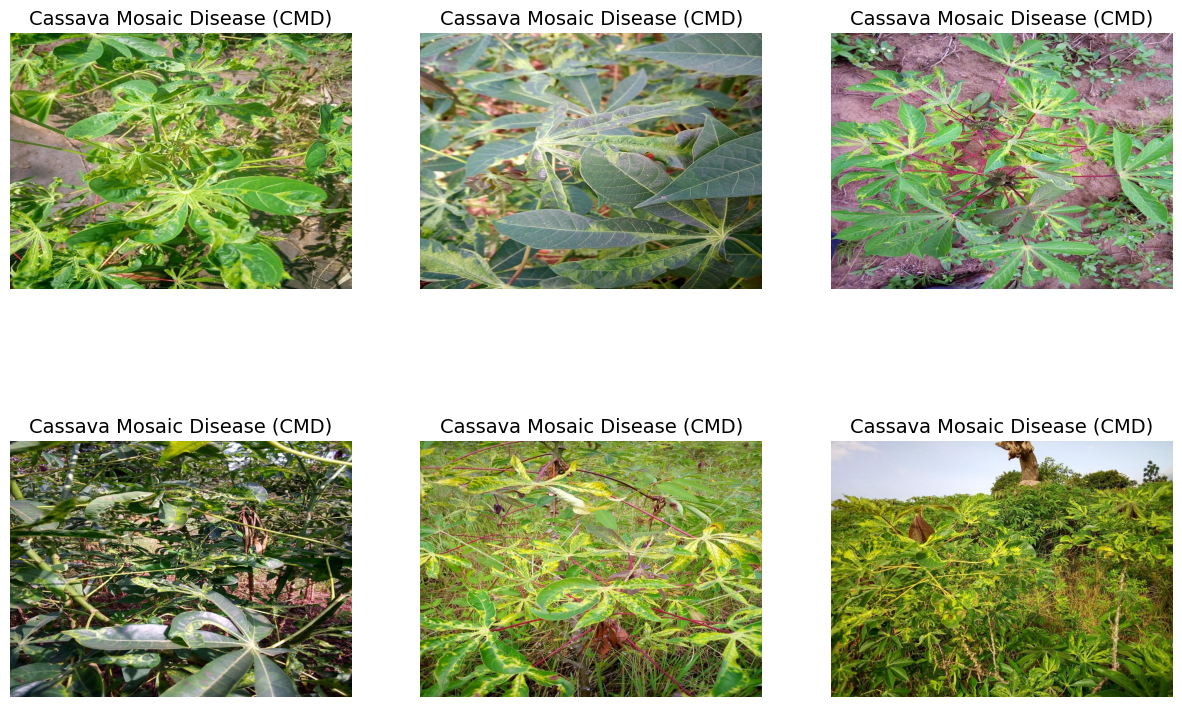

In [10]:
plot_images(3, mapping[3], 6)

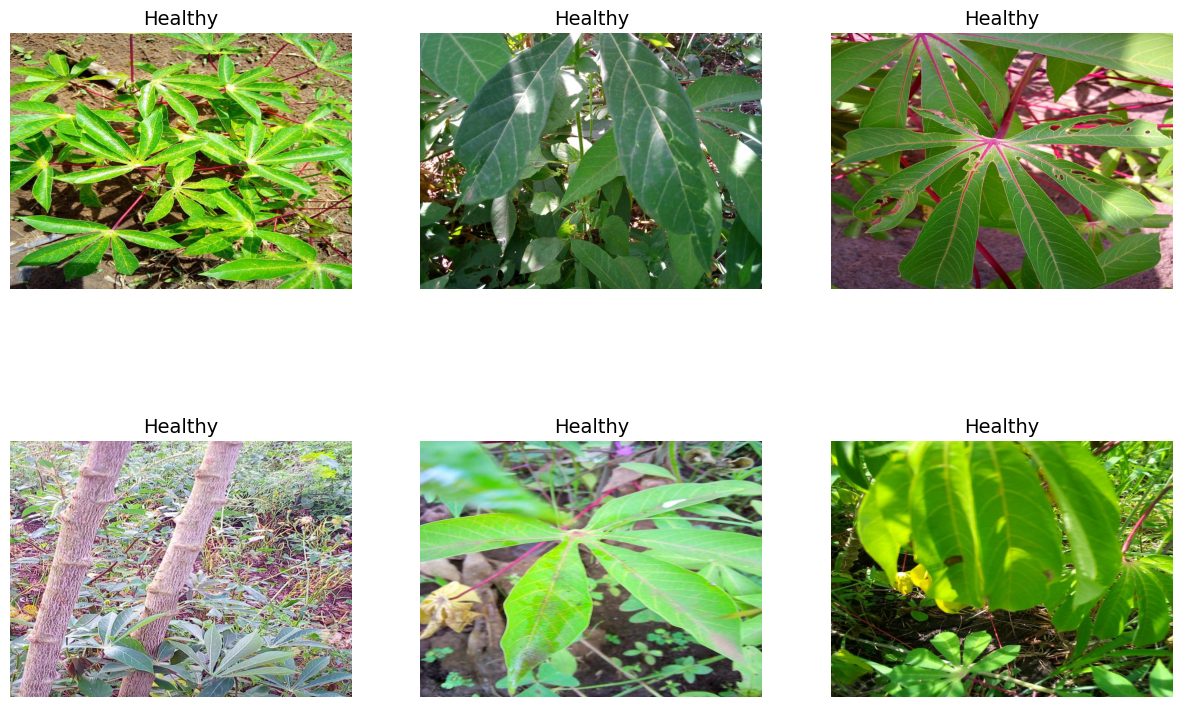

In [11]:
plot_images(4, mapping[4], 6)

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'Cassava Mosaic Disease (CMD)'),
  Text(1, 0, 'Healthy'),
  Text(2, 0, 'Cassava Green Mottle (CGM)'),
  Text(3, 0, 'Cassava Brown Streak Disease (CBSD)'),
  Text(4, 0, 'Cassava Bacterial Blight (CBB)')])

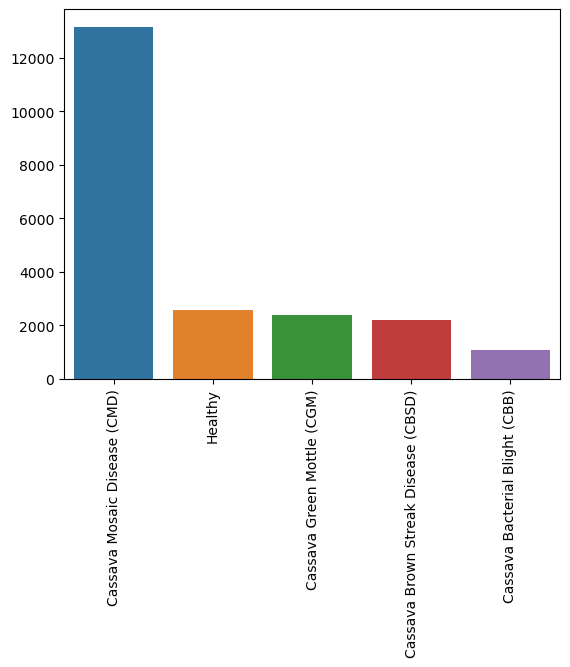

In [12]:
# 클래스 분포 확인

class_counts = train['label_names'].value_counts()
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.xticks(rotation=90)

# 설정

In [13]:
DIM = (256, 256)      # 이미지 너비, 높이
WIDTH, HEIGHT = DIM           

NUM_CLASSES = 5    # 클래스의 개수
NUM_WORKERS = 24  # 데이터 로딩을 위한 worker의 개수

TRAIN_BATCH_SIZE = 32        
TEST_BATCH_SIZE = 32         

SEED = 1                     

DEVICE = 'cuda'            

MEAN = [0.485, 0.456, 0.406]  # 이미지의 각 채널별 평균 값
STD = [0.229, 0.224, 0.225]    # 이미지의 각 채널별 표준 편차 값


# 증강

In [14]:
def get_test_transforms(value='val'):
    # 'train' 값이 주어진 경우
    if value == 'train':
        return albumentations.Compose([
            albumentations.Resize(WIDTH, HEIGHT),  # 이미지 크기 조정
            albumentations.HorizontalFlip(p=0.5),  # 수평 방향으로 뒤집기
            albumentations.Rotate(limit=(-90, 90)),  # 이미지 회전
            albumentations.VerticalFlip(p=0.5),  # 수직 방향으로 뒤집기
            albumentations.Normalize(MEAN, STD, max_pixel_value=255.0, always_apply=True),  # 이미지 정규화
            ToTensorV2(p=1.0)  # 텐서로 변환!!
        ])
    # 'val' 값이 주어진 경우
    elif value == 'val':
        return albumentations.Compose([
            albumentations.Resize(WIDTH, HEIGHT),  # 이미지 크기 정해진 사이즈로 조정
            albumentations.Normalize(MEAN, STD, max_pixel_value=255.0, always_apply=True),  # 이미지 정규화
            ToTensorV2(p=1.0)  # 텐서로 변환!!
        ])


# Dataset Loader Class
- CassavaDataset 클래스를 정의하여 데이터셋 내의 이미지와 레이블을 쉽게 액세스하고 변환하는 기능을 제공하여 모델 훈련 및 평가 과정을 간편하게 처리

In [15]:
class CassavaDataset(Dataset):
    def __init__(self, image_ids, labels, dimension=None, augmentations=None, folder='train_images'):
        super().__init__()
        self.image_ids = image_ids  # 이미지 ID 리스트
        self.labels = labels           # 레이블 리스트
        self.dim = dimension           # 이미지 크기
        self.augmentations = augmentations # 데이터 증강을 위한 변환
        self.folder = folder          # 이미지 폴더 위치
    
    # 데이터셋 길이를 반환하는 메서드
    def __len__(self):
        return len(self.image_ids)
    
    # 주어진 인덱스에 해당하는 이미지와 레이블을 반환하는 메서드
    def __getitem__(self, idx):
        img = Image.open(os.path.join(BASE_DIR, self.folder, self.image_ids[idx]))  # 이미지 파일 열기
        
        if self.dim:
            img = img.resize(self.dim)   # 이미지 크기 조정
        
        img = np.array(img)   # 이미지를 NumPy 배열로 변환
        
        if self.augmentations:
            augmented = self.augmentations(image=img)   # 이미지 증강
            img = augmented['image']
        
        label = torch.tensor(self.labels[idx], dtype=torch.long)   # 레이블을 텐서로 변환
        return img, label




# 훈련-테스트 데이터 나누기

In [16]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(train['image_id'], train['label'], test_size=0.25)

In [17]:
# 클래스 불균형 문제를 해결하기 위한 클래스 생성

from torch.utils.data import WeightedRandomSampler

def sampler_(labels):
    label_unique, counts = np.unique(labels, return_counts=True)  # 레이블의 고유값과 개수를 계산
    print('Unique Labels:', label_unique)
    weights = [sum(counts) / c for c in counts]  # 클래스 불균형을 보정하기 위한 가중치 계산
    sample_weights = [weights[w] for w in labels]  # 각 샘플에 해당하는 가중치 리스트 생성
    sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)  # 가중치를 기반으로 샘플링하는 가중치 랜덤 샘플러 생성
    return sampler


In [18]:
train_sampler = sampler_(y_train)

Unique Labels: [0 1 2 3 4]


In [19]:
# 훈련 및 검증용 데이터셋 생성
train_dataset = CassavaDataset(
    image_ids=x_train.values,
    labels=y_train.values,
    augmentations=get_test_transforms('train'),
    dimension=DIM
)

# 훈련 데이터 로더 생성
train_loader = DataLoader(
    train_dataset,
    batch_size=TRAIN_BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=False,
    sampler=train_sampler
)

# 검증용 데이터셋 생성
val_dataset = CassavaDataset(
    image_ids=x_test.values,
    labels=y_test.values,
    augmentations=get_test_transforms('val'),
    dimension=DIM
)

# 검증 데이터 로더 생성
val_loader = DataLoader(
    val_dataset,
    batch_size=TRAIN_BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=False
)

# 데이터 로더들을 딕셔너리에 저장
loaders = {'train': train_loader, 'val': val_loader}


In [20]:
# 데이터 셋 작동 테스트
# 데이터셋에서 인덱스에 해당하는 데이터 가져오기 
val_dataset[0]


(tensor([[[-1.1932, -0.9192, -0.4054,  ..., -0.9020, -0.9877, -1.0733],
          [-0.9020, -0.3198, -0.0629,  ..., -1.0390, -1.0904, -0.8849],
          [-0.0972,  0.0741, -0.4739,  ..., -0.9705, -1.0390, -1.0048],
          ...,
          [-1.2445, -0.7822, -0.7822,  ..., -0.9877, -0.8678, -0.6965],
          [-1.5014, -1.3302, -0.9877,  ..., -0.8678, -0.9192, -0.9192],
          [-1.5699, -1.6213, -1.4843,  ..., -0.5596, -0.6281, -0.8678]],
 
         [[-0.3550, -0.0749,  0.4503,  ..., -1.2479, -1.3179, -1.3880],
          [-0.0574,  0.5203,  0.7304,  ..., -1.4055, -1.4405, -1.2304],
          [ 0.7129,  0.8354,  0.2052,  ..., -1.3529, -1.4055, -1.3704],
          ...,
          [-1.3004, -0.8277, -0.7752,  ..., -1.3880, -1.3529, -1.1604],
          [-1.3354, -1.2129, -0.8627,  ..., -1.1604, -1.2304, -1.1604],
          [-1.1779, -1.3354, -1.2829,  ..., -0.7402, -0.7577, -0.8627]],
 
         [[-0.1835,  0.1128,  0.6705,  ..., -0.0441, -0.2184, -0.3230],
          [ 0.1302,  0.7228,

# 전이 훈련

In [21]:
def getModel():
    # 미리 학습된 ResNet-152 모델 불러오기
    net = models.resnet152(pretrained=True)
    
    # 네트워크의 파라미터 고정 (전체 학습시키지 않고, 일부만 학습시키려면 주석 처리)
    #for param in net.parameters():
    #    param.requires_grad = False
        
    # 네트워크의 마지막 fully connected 레이어 수정하기
    num_ftrs = net.fc.in_features
    net.fc = nn.Sequential(
        nn.Linear(num_ftrs, 256),  # 256차원의 fully connected 레이어 추가
        nn.ReLU(),  # 활성화 함수 ReLU 적용
        nn.Dropout(0.3),  # 드롭아웃 적용
        nn.Linear(256, NUM_CLASSES),  # 클래스 수에 해당하는 출력 레이어 추가
        nn.LogSoftmax(dim=1)  # LogSoftmax 함수 적용
    )
    
    # GPU 사용 가능하면 사용
    net = net.cuda() if DEVICE else net
    
    return net



In [22]:
model = getModel()


Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:03<00:00, 63.5MB/s] 


In [23]:
import math

def cyclical_lr(stepsize, min_lr=3e-4, max_lr=3e-3):
    # 스케일러: 삼각형 CLR 이외의 다른 스케줄링을 원한다면 이 부분 수정
    scaler = lambda x: 1.

    # 학습계산을 위한 람다 함수
    lr_lambda = lambda it: min_lr + (max_lr - min_lr) * relative(it, stepsize)

    # 주기의 어디에 위치해 있는지 확인하기 위한 함수
    def relative(it, stepsize):
        cycle = math.floor(1 + it / (2 * stepsize))
        x = abs(it / stepsize - 2 * cycle + 1)
        return max(0, (1 - x)) * scaler(cycle)

    return lr_lambda


In [24]:
#  손실 함수, 옵티마이저, 학습률 스케줄러를 설정

criterion = nn.CrossEntropyLoss()  # 손실 함수로 CrossEntropyLoss 사용

# 옵티마이저 설정
# Adam 옵티마이저
# optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
# SGD 옵티마이저
optimizer = torch.optim.SGD(model.parameters(), lr=1., momentum=0.9)

step_size = 4 * len(train_loader)  # 주기의 크기 설정
clr = cyclical_lr(step_size, min_lr=3e-4, max_lr=3e-3)  # 주기적 학습률 생성 함수 호출
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, [clr])  # 주기적 학습률 스케줄러 설정


In [25]:
unfreeze = True  # unfreeze를 False로 설정하면 레이어를 동결

# 모델의 모든 파라미터 동결 여부
for param in model.parameters():
    param.requires_grad = unfreeze


In [26]:
total_params = sum(p.numel() for p in model.parameters())  # 총 파라미터 개수 계산
print(f'{total_params:,} total parameters')

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)  # 학습 가능한 파라미터 개수 계산
print(f'{trainable_params:,} training parameters')


58,669,637 total parameters
58,669,637 training parameters


In [27]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=5, scheduler=scheduler):
    # 시작 시간 설정
    start_time = time.time()
    
    val_acc_history = []  # 검증 정확도 기록
    
    best_model_wts = copy.deepcopy(model.state_dict())  # 가장 좋은 모델 가중치 저장
    best_acc = 0.0  # 최고 정확도 초기화
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs-1}')
        print('-' * 15)
        
        # 각 에폭은 훈련 및 검증 단계를 가짐
        for phase in ['train', 'val']:
            # 모델의 모드 설정
            if phase == 'train':
                model.train()  # 모델을 훈련 모드로 설정
            else:
                model.eval()  # 모델을 평가 모드로 설정
                
            running_loss = 0.0  # 러닝 손실 초기화
            running_corrects = 0  # 러닝 정확도 초기화
            
            # 데이터 반복
            for inputs, labels in dataloaders[phase]:
                # 데이터를 해당 하드웨어로 이동
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)
                
                # 파라미터 그래디언트 초기화
                optimizer.zero_grad()
                
                # 훈련 또는 검증 과정
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    
                    _, preds = torch.max(outputs, 1)
                    
                    # 네트워크 내에서 역전파
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        scheduler.step()
                        
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            # 에폭에 대한 손실과 정확도 계산
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            # 훈련 및 검증에 대한 손실과 정확도 출력
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            # 최고 정확도를 업데이트하고 가장 좋은 가중치 저장
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                
        print()
        
    end_time = time.time() - start_time
    
    print('Training completes in {:.0f}m {:.0f}s'.format(end_time // 60, end_time % 60))
    print('Best Val Acc: {:.4f}'.format(best_acc))
    
    # 가장 좋은 가중치를 모델에 로드
    model.load_state_dict(best_model_wts)
    
    return model, val_acc_history


In [28]:
# 모델 트레이닝
model, accuracy = train_model(model=model, dataloaders=loaders, criterion=criterion, optimizer=optimizer, num_epochs=5, scheduler=scheduler)

Epoch 0/4
---------------
train Loss: 1.2397 Acc: 0.5097
val Loss: 0.6529 Acc: 0.7615

Epoch 1/4
---------------
train Loss: 0.7296 Acc: 0.7345
val Loss: 0.5499 Acc: 0.8043

Epoch 2/4
---------------
train Loss: 0.5968 Acc: 0.7884
val Loss: 0.6150 Acc: 0.7897

Epoch 3/4
---------------
train Loss: 0.5496 Acc: 0.8040
val Loss: 0.5897 Acc: 0.8097

Epoch 4/4
---------------
train Loss: 0.4825 Acc: 0.8306
val Loss: 0.5545 Acc: 0.8189

Training completes in 27m 21s
Best Val Acc: 0.8189


In [29]:
# 베스트 모델과 가중치 저장
torch.save(model, '/best_model.h5')
torch.save(model.state_dict(), '//best_model_weights')

In [30]:
# 모든 레이어의 동결 (또는 해제)
unfreeze = True  # 동결 해제하려면 False로 설정
for param in model.parameters():
    param.requires_grad = unfreeze


In [31]:
# 총 파라미터와 학습 가능한 파라미터 찾기
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters')
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'{trainable_params:,} training parameters')


58,669,637 total parameters
58,669,637 training parameters


# 모델 테스트

In [32]:
# CUDA 장치에서 캐시 비우기
torch.cuda.empty_cache()


In [33]:
# 모델을 사용하여 데이터셋 예측하는 함수

def predict(model, dataloader, device):
    # eval 모드로 설정
    model.eval()
    fin_out = []
    
    with torch.no_grad():
        for images, targets in dataloader:
            images = images.to(device)
            targets = targets.to(device)
            
            outputs = model(images)
            
            fin_out.append(F.softmax(outputs, dim=1).detach().cpu().numpy())
            
    return np.concatenate(fin_out)


In [34]:
# 모델 예측 단계
device = torch.device('cuda')  
model.to(device)
pred = predict(model, val_loader, device)
pred = pred.argmax(axis=1)


In [35]:
y_test.values[:5]

array([3, 4, 3, 3, 0])

In [36]:
pred[:5]

array([3, 4, 3, 3, 0])